In [1]:

import numpy as np
import galsim
import torch
import torch.nn.functional as F
from bliss.models.decoder import get_mgrid
from bliss.datasets.galsim_galaxies import GalsimBlends
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
from torch import Tensor
from typing import Dict, Optional
import pytorch_lightning as pl
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.models.galsim_decoder import SingleGalsimGalaxyDecoder,SingleGalsimGalaxyPrior,UniformGalsimGalaxiesPrior

from case_studies.coadds.align_single_exposures import align_single_exposures

In [2]:
def render_galaxy(
        self,
        galaxy_params: Tensor,
        psf: galsim.GSObject,
        slen: int,
        offset: Optional[Tensor] = None,
        dithers: Optional[Tensor] = None,
    ) -> Tensor:
        assert offset is None or offset.shape == (2,)
        if isinstance(galaxy_params, Tensor):
            galaxy_params = galaxy_params.cpu().detach()
        total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params
        bulge_frac = 1 - disk_frac

        disk_flux = total_flux * disk_frac
        bulge_flux = total_flux * bulge_frac

        components = []
        if disk_flux > 0:
            b_d = a_d * disk_q
            disk_hlr_arcsecs = np.sqrt(a_d * b_d)
            disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
                q=disk_q,
                beta=beta_radians * galsim.radians,
            )
            components.append(disk)
        if bulge_flux > 0:
            b_b = bulge_q * a_b
            bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
            bulge = galsim.DeVaucouleurs(
                flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
            ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
            components.append(bulge)
        galaxy = galsim.Add(components)
        gal_conv = galsim.Convolution(galaxy, psf)
        offset = (0,0) if offset is None else offset
        dithers = (0,0) if dithers is None else dithers
        shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
        shift = shift.reshape(1,2) if len(shift) == 2 else shift
        images = []
        for i in shift:
            image = gal_conv.drawImage(
                nx=slen, ny=slen, method="auto", scale=self.pixel_scale, offset=i
            )
            image = image.array
            images.append(image)
        return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)

In [3]:
with initialize(config_path="./case_studies/sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

In [4]:
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
psf = decoder.psf
prior = instantiate(cfg.datasets.galsim_blended_galaxies.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = GalsimBlends(prior = prior, decoder = decoder, background = background, tile_slen = tile_slen, max_sources_per_tile = max_tile_n_sources, num_workers = num_workers, batch_size = batch_size, n_batches = n_batches)._sample_full_catalog()

In [5]:
# create dithers
n = 3
dithers = [((-0.5 - 0.5) * torch.rand((2,)) + 0.5).numpy() for x in range(n)]

In [6]:
size = decoder.slen + 2 * decoder.bp
full_plocs = full_catalog.plocs
b, max_n_sources, _ = full_plocs.shape

image = torch.zeros(len(dithers), 1, size, size)
image0 = torch.zeros(1, 1, size, size)
noiseless_centered = torch.zeros(len(dithers), max_n_sources, 1, size, size)
noiseless_uncentered = torch.zeros(len(dithers), max_n_sources, 1, size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

offset_x = plocs[0][1] + decoder.bp - size / 2
offset_y = plocs[0][0] + decoder.bp - size / 2
offset = torch.tensor([offset_x, offset_y])
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
uncentered = render_galaxy(decoder, galaxy_params[0], psf, size, offset)
uncentered_dithered = render_galaxy(decoder, galaxy_params[0], psf, size, offset, dithers)

/tmp/ipykernel_1533762/2763212682.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)


In [7]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline 

Modules to reload:
all-except-skipped

Modules to skip:



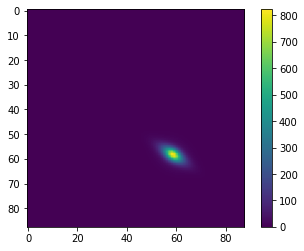

In [8]:
plt.figure()
plt.imshow(uncentered.reshape(size,size))
plt.colorbar()

In [9]:
%store uncentered

Stored 'uncentered' (Tensor)


In [1]:
import numpy as np
import sep

%store -r uncentered

In [5]:
objects = sep.extract(uncentered.reshape(88,88).numpy(), 1.5)

In [6]:
len(objects)

1

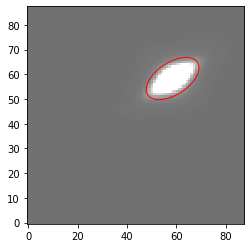

In [9]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from matplotlib import rcParams

data_sub = uncentered.reshape(88,88).numpy()

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)